In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import os
import cv2
from PIL import Image


from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [3]:
# Dataset directories
training_path = './Training/'
testing_path = './Testing'
os.listdir(testing_path)


['glioma', 'meningioma', 'notumor', 'pituitary']

In [4]:
# Custom Dataset Class for loading and retrieving samples
from torchvision.io import read_image

class TumorDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.dataset_dir = img_dir
        self.category_dir = os.listdir(img_dir)
        self.data = self.load_data()
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def load_data(self):
        data = []
        for i , category in enumerate(self.category_dir):
            category_path = os.path.join(self.dataset_dir , category)
            for file_name in os.listdir(category_path):
                img_path = os.path.join(category_path , file_name)
                data.append([img_path , i])
        return data

    def __getitem__(self, idx):
        img_path , label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(label)
        if self.transform:
            tansformed_image = self.transform(image)
            
        return tansformed_image.to(device) , label.to(device)


In [5]:
# Transformations to the data
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1858, 0.1858, 0.1859), (0.1841, 0.1841, 0.1841))
])

In [6]:
# Create separate train, test and validation datasets
train_data = TumorDataset(training_path,  transform)
test_data = TumorDataset(testing_path, transform )

In [7]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

In [8]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

4569
1143
1311


In [9]:
# Dataloader for each set, to create batches
train_loader = DataLoader(dataset = train_data, batch_size = 16, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset = val_data, batch_size = 16, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = 16, shuffle=True, num_workers=0)

In [ ]:
# https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/2
# Calculate meman and variance of dataset
mean = 0.
std = 0.
for images, _ in val_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    
for images, _ in train_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    
for images, _ in test_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(train_loader.dataset + val_loader.dataset + test_loader.dataset)
std /= len(train_loader.dataset + val_loader.dataset + test_loader.dataset)


print(mean)
print(std)

C:\Users\julia\AppData\Local\Temp\ipykernel_29532\3077884524.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3618.)
  plt.imshow(img.T, cmap="gray")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([16, 3, 300, 300])
Labels batch shape: torch.Size([16])


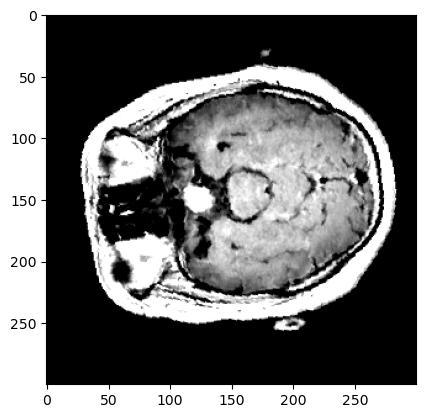

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 3


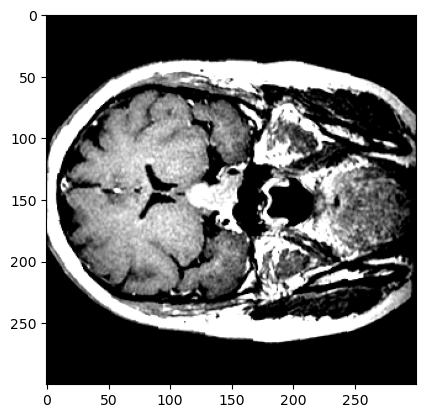

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 3


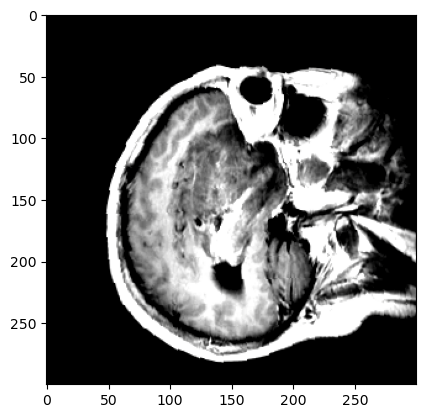

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0


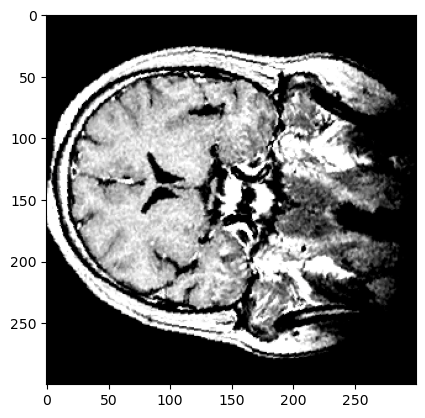

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 3


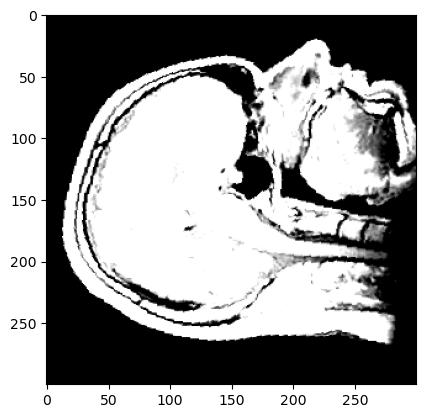

Label: 2


In [10]:
# Dataset visualization
trainimages, trainlabels = next(iter(train_loader))

print(f"Feature batch shape: {trainimages.size()}")
print(f"Labels batch shape: {trainlabels.size()}")
for i in range(5):
    img = trainimages[i].squeeze().cpu()
    label = trainlabels[i]
    plt.imshow(img.T, cmap="gray")
    plt.show()
    print(f"Label: {label}")

In [11]:
# CNN Architecture without backbone
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights, vgg16


cnn = models.vgg16(pretrained=True)

modules = list(cnn.children())[:-1]
cnn = torch.nn.Sequential(*modules)
for param in cnn.parameters():
    param.requires_grad = False

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 36, kernel_size=3)
        self.fc1 = nn.Linear(191844, 1024)
        self.fc2 = nn.Linear(1024, 4)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

C:\Users\julia\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\julia\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# CNN Architecture
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights, vgg16


cnn = models.vgg16(pretrained=True)

modules = list(cnn.children())[:-1]
cnn = torch.nn.Sequential(*modules)
for param in cnn.parameters():
    param.requires_grad = False

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()        
        self.cnn = cnn
        self.fc1 = nn.Linear(25088, 1024)
        self.fc2 = nn.Linear(1024, 4)
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [13]:
# Model instantiation
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [14]:
%%time
train_losses = []
valid_losses = []

for epoch in range(1, 20 + 1):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Start training
    model.train()
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    # Validation
    model.eval()
    for data, target in val_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        valid_loss += loss.item() * data.size(0)
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.793825 	Validation Loss: 0.369836
Epoch: 2 	Training Loss: 0.328684 	Validation Loss: 0.226138
Epoch: 3 	Training Loss: 0.287577 	Validation Loss: 0.215151
Epoch: 4 	Training Loss: 0.258995 	Validation Loss: 0.226709
Epoch: 5 	Training Loss: 0.229193 	Validation Loss: 0.206151
Epoch: 6 	Training Loss: 0.228183 	Validation Loss: 0.166628
Epoch: 7 	Training Loss: 0.205487 	Validation Loss: 0.176978
Epoch: 8 	Training Loss: 0.211888 	Validation Loss: 0.128141
Epoch: 9 	Training Loss: 0.180382 	Validation Loss: 0.182412
Epoch: 10 	Training Loss: 0.194882 	Validation Loss: 0.219758
Epoch: 11 	Training Loss: 0.171597 	Validation Loss: 0.213058
Epoch: 12 	Training Loss: 0.162163 	Validation Loss: 0.164122
Epoch: 13 	Training Loss: 0.163702 	Validation Loss: 0.179298
Epoch: 14 	Training Loss: 0.182353 	Validation Loss: 0.179022
Epoch: 15 	Training Loss: 0.148315 	Validation Loss: 0.213002
Epoch: 16 	Training Loss: 0.175032 	Validation Loss: 0.182886
Epoch: 17 	Traini

# Evaluation

In [15]:
model.eval()
predictions = []
truth = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predictions.extend(predicted.cpu())
        truth.extend(labels.cpu())
        correct += (predicted == labels).sum().item()
     
    
print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Test Accuracy of the model: 95.95728451563691 %


Test Accuracy of the model: 95.95728451563691 %
Precision: 0.9581993899627725
Recall: 0.9570733478576616


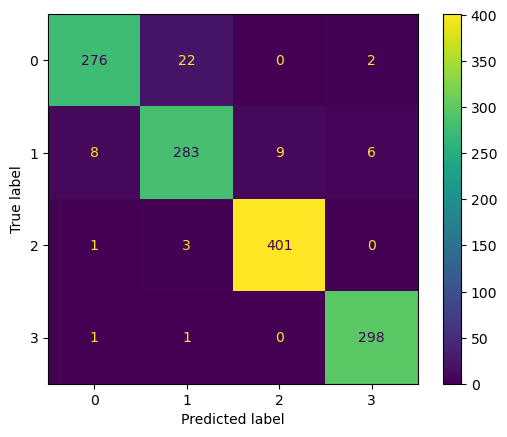

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score

print('Test Accuracy of the model: {} %'.format(100 * correct / total))
cm = confusion_matrix(truth, predictions)
print('Precision: ' + str(precision_score(truth, predictions, average='macro')))
print('Recall: ' + str(recall_score(truth, predictions, average='macro')))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

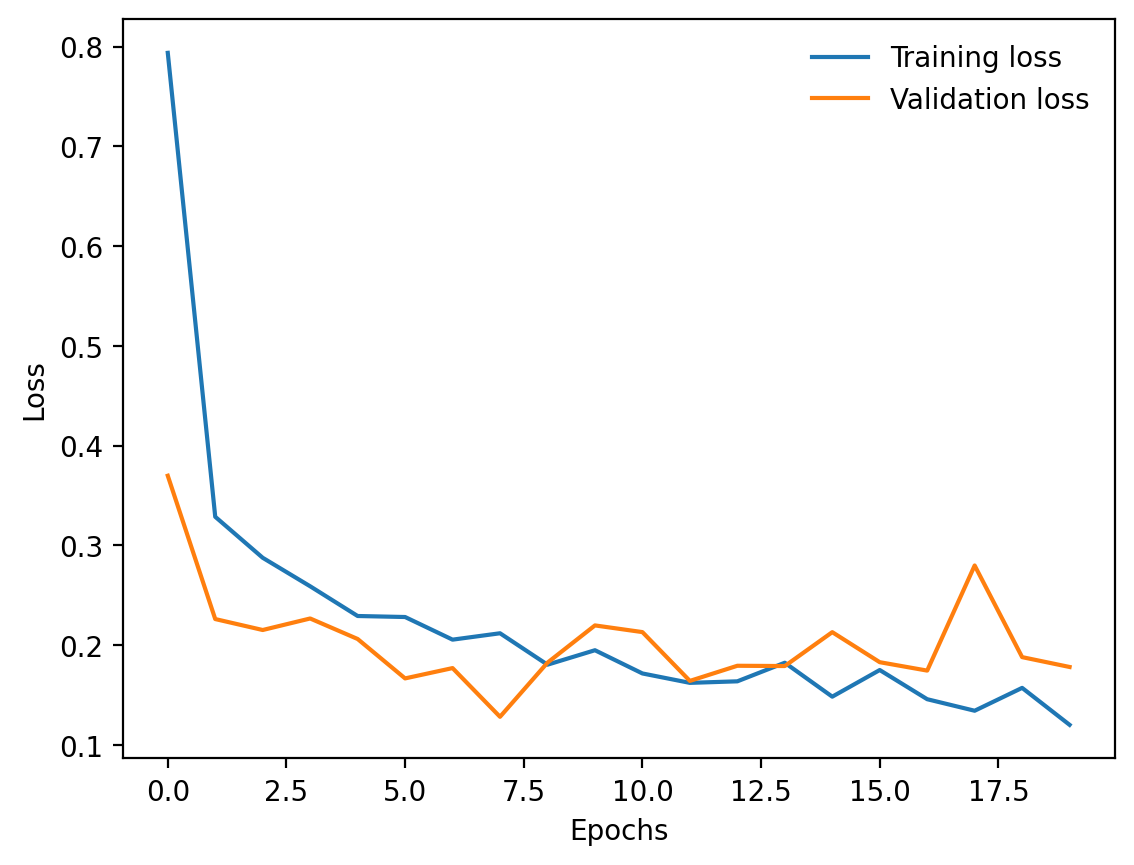

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)